### Student Information
Name: Aliah Gie F. Zabala

Student ID: 113065424

GitHub ID: 182365283

Kaggle name: Aliah Gie Zabala

Kaggle private scoreboard snapshot: 
![pic0.png](img\pic0.png)

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home exercises** in the [DM2024-Lab2-master Repo](https://github.com/didiersalazar/DM2024-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework) regarding Emotion Recognition on Twitter by this link: https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (0.6N + 1 - x) / (0.6N) * 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 * 100 + 1 - 3) / (0.6 * 100) * 10 + 20 = 29.67% out of 30%.)   
    Submit your last submission **BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)**. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developing the model for the competition (You can use code and comment on it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)__. 

# Prepare Dataset

In [2]:
### Begin Assignment Here
import pandas as pd
import json
import numpy as np
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Read JSON file
df = pd.read_json('tweets_DM.json', lines=True)

In [2]:
source_df = pd.json_normalize(df['_source'])

In [3]:
source_df # Dataset

,tweet.hashtags,tweet.tweet_id,tweet.text
0,[Snapchat],0x376b20,"People who post ""add me on #Snapchat"" must be ..."
1,"[freepress, TrumpLegacy, CNN]",0x2d5350,"@brianklaas As we see, Trump is dangerous to #..."
2,[bibleverse],0x28b412,"Confident of your obedience, I write to you, k..."
3,[],0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>
4,[],0x2de201,"""Trust is not the same as faith. A friend is s..."
...,...,...,...
1867530,"[mixedfeeling, butimTHATperson]",0x316b80,When you buy the last 2 tickets remaining for ...
1867531,[],0x29d0cb,I swear all this hard work gone pay off one da...
1867532,[],0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...
1867533,[],0x24faed,"Ah, corporate life, where you can date <LH> us..."


In [82]:
# Keep all columns from original df except '_source'
final_df = source_df.copy()

# Concatenate the DataFrames horizontally
final_df.rename(columns={'tweet.tweet_id': 'tweet_id', 'tweet.hashtags':'hashtags', 'tweet.text':'text'}, inplace=True)

final_df= final_df[['tweet_id', 'hashtags', 'text']]

In [83]:
final_df

,tweet_id,hashtags,text
0,0x376b20,[Snapchat],"People who post ""add me on #Snapchat"" must be ..."
1,0x2d5350,"[freepress, TrumpLegacy, CNN]","@brianklaas As we see, Trump is dangerous to #..."
2,0x28b412,[bibleverse],"Confident of your obedience, I write to you, k..."
3,0x1cd5b0,[],Now ISSA is stalking Tasha 😂😂😂 <LH>
4,0x2de201,[],"""Trust is not the same as faith. A friend is s..."
...,...,...,...
1867530,0x316b80,"[mixedfeeling, butimTHATperson]",When you buy the last 2 tickets remaining for ...
1867531,0x29d0cb,[],I swear all this hard work gone pay off one da...
1867532,0x2a6a4f,[],@Parcel2Go no card left when I wasn't in so I ...
1867533,0x24faed,[],"Ah, corporate life, where you can date <LH> us..."


In [84]:
# Load emotion labels
emotion_df = pd.read_csv('emotion.csv')

# Load train/test identification
identification_df = pd.read_csv('data_identification.csv')
    
# Merge datasets

# First, merge tweets with identification
merged_df = final_df.merge(identification_df, on='tweet_id', how='inner')
    
# Then, merge with emotion labels
merged_df = merged_df.merge(emotion_df, on='tweet_id', how='left')
    
# Split into train and test based on 'identification' column
train_df = merged_df[merged_df['identification'] == 'train']
test_df = merged_df[merged_df['identification'] == 'test']

# Drop the identification column in both training and test sets
train_df = train_df.drop('identification', axis=1)
test_df = test_df.drop('identification', axis=1)

# Drop the emotion column in test set 
test_df = test_df.drop('emotion', axis=1)

In [85]:
train_df.head(5)

,tweet_id,hashtags,text,emotion
0,0x376b20,[Snapchat],"People who post ""add me on #Snapchat"" must be ...",anticipation
1,0x2d5350,"[freepress, TrumpLegacy, CNN]","@brianklaas As we see, Trump is dangerous to #...",sadness
3,0x1cd5b0,[],Now ISSA is stalking Tasha 😂😂😂 <LH>,fear
5,0x1d755c,"[authentic, LaughOutLoud]",@RISKshow @TheKevinAllison Thx for the BEST TI...,joy
6,0x2c91a8,[],Still waiting on those supplies Liscus. <LH>,anticipation


In [86]:
test_df.head(5)

,tweet_id,hashtags,text
2,0x28b412,[bibleverse],"Confident of your obedience, I write to you, k..."
4,0x2de201,[],"""Trust is not the same as faith. A friend is s..."
9,0x218443,"[materialism, money, possessions]",When do you have enough ? When are you satisfi...
30,0x2939d5,"[GodsPlan, GodsWork]","God woke you up, now chase the day #GodsPlan #..."
33,0x26289a,[],"In these tough times, who do YOU turn to as yo..."


# Data Preprocessing

## Exploratory data analysis (EDA)

In [93]:
# group to find distribution
train_df.groupby(['emotion']).count()['text']

emotion
anger            39867
anticipation    248935
disgust         139101
fear             63999
joy             516017
sadness         193437
surprise         48729
trust           205478
Name: text, dtype: int64

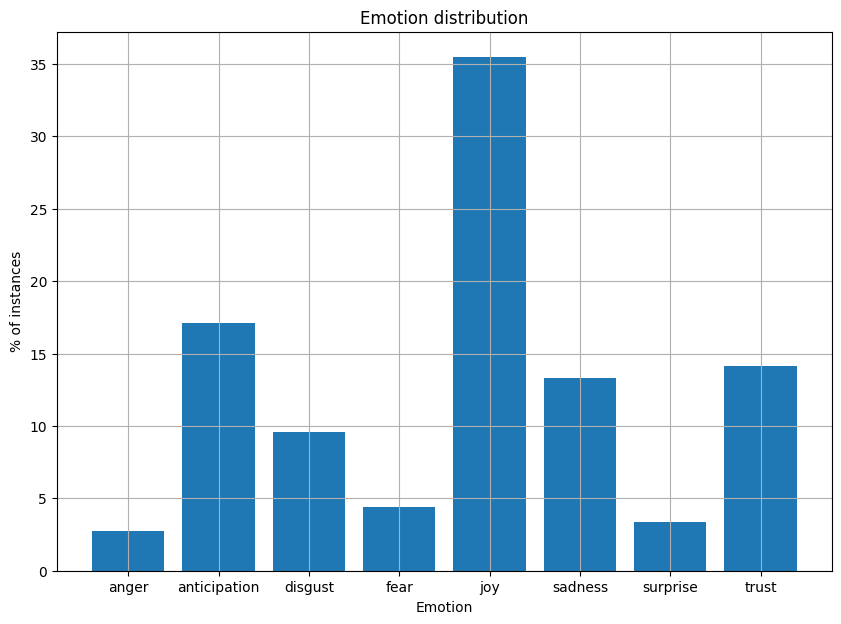

In [22]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# the histogram of the data
labels = train_df['emotion'].unique()
post_total = len(train_df)
df1 = train_df.groupby(['emotion']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(10, 7))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.grid(True)
plt.show()

## Preprocessing Steps

1. Emoji Processing

    * Extracts and counts emoji occurrences in text
    * Converts emojis to readable text format (e.g., "😊" to "emoji_smilingface")
    * Include emoji frequency information (e.g., "emoji_smilingface_3x" for repeated emojis)

2. Text Cleaning

    * Converts text to lowercase while preserving significant uppercase patterns
    * Conversion happens after uppercase word detection to preserve the uppercase patterns

3. Special Character Handling:

    * Removes URLs, mentions (@user), and hashtags (#topic)
        - Hashtags will be concatenated later.
    * Standardizes multiple punctuation marks (e.g., "..." → "....")
    * Preserves punctuation patterns ("!!", "??")
    * Identifies and marks words in all caps (excluding "LH")
        - Example: "HAPPY" to "uppercase_happy"
    * Removes other non-word characters
    * Standardizes various forms of "LH" ("LH", "<LH>", "lh") to consistent format
    * Skips very short words (<= 2 characters) and standalone periods

4. More Text Processing

    * Stopword Removal: Removes common English stopwords while preserving meaningful terms such as:
    
        - Emotional/contextual words: "not", "no", "never", "against"
        - Intensity indicators: "very", "so", "too", "only"
        - Directional/spatial words: "up", "down", "in", "out"
    
    * Stemming:
        - Applied Porter Stemmer to reduce words to their root form BUT after randomly peeking data, the results weren't good
        - Switched to spacy

5. Label Encoding

    * Implements label encoding for emotion categories in training data
    * Provides distribution statistics for emotion labels in training data

In [111]:
import nltk
import re
import emoji
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy
from sklearn.preprocessing import LabelEncoder
from collections import Counter

In [112]:
# Extract emojis and count their occurrences
def extract_emojis(text):
    emoji_counter = Counter()
    clean_text = ""
    
    for char in text:
        if char in emoji.EMOJI_DATA:
            emoji_counter[char] += 1
        else:
            clean_text += char
            
    return emoji_counter, clean_text

In [113]:
def preprocess_text(text):
    text = str(text)
    
    # 1. Extract and count emojis before preprocessing
    emoji_counter, text = extract_emojis(text)
    
    # 2. Find uppercase words (words with 2 or more uppercase letters)
    uppercase_words = re.findall(r'\b[A-Z][A-Z]+\b', text)
    
    # 3. Cleaning
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags completely
    
    # 4. Handle punctuation
    text = re.sub(r'\.{2,}', ' .... ', text)  # Convert multiple dots to ....
    text = re.sub(r'!{2,}', ' !! ', text)     # Convert multiple ! to !!
    text = re.sub(r'\?{2,}', ' ?? ', text)    # Convert multiple ? to ??
    text = re.sub(r'[^\w\s!?.]', ' ', text)   # Remove other punctuation
    text = re.sub(r'\s*\.\s*', ' ', text)     # Remove standalone periods
    
    # 5. Remove extra whitespace
    text = ' '.join(text.split())
    
    # 6. Initialize tokens list
    tokens = []
    
    # 7. Add base text tokens
    tokens.extend(text.split())
    
    # 8. Add uppercase markers (excluding LH)
    uppercase_tokens = [f"uppercase_{word.lower()}" for word in uppercase_words 
                       if word.lower() not in ['lh']]
    tokens.extend(uppercase_tokens)
    
    # 9. Add emoji tokens with counts
    for emoji_char, count in emoji_counter.items():
        emoji_name = emoji.demojize(emoji_char).strip(':').replace('_', '')
        if count > 1:
            tokens.append(f"emoji_{emoji_name}_{count}x")
        else:
            tokens.append(f"emoji_{emoji_name}")
    
    # 10. Convert "lh" variations to consistent format
    tokens = ['lh' if t in ['lh', '<lh>', 'LH', '<LH>'] else t for t in tokens]
    
    return ' '.join(tokens)

In [12]:
def preprocess_data(df, text_column='text'):
    # Load spaCy model (needs: python -m spacy download en_core_web_sm)
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    
    df_processed = df.copy()
    
    # 11. Missing values
    df_processed = df_processed.assign(
        **{text_column: df_processed[text_column].fillna('')}
    )
    
    # 12. Clean text
    df_processed['cleaned_text'] = df_processed[text_column].apply(preprocess_text)
    
    # 13. Stopwords
    stop_words = set(stopwords.words('english'))
    
    # Keep only very specific emotional/meaningful stopwords
    keep_words = {
        'not', 'no', 'never', 'against',
        'very', 'so', 'too', 'only',
        'up', 'down', 'in', 'out'
    }
    stop_words = stop_words - keep_words
    
    def tokenize_and_lemmatize(text):
        tokens = text.split()
        processed_tokens = []
        
        for token in tokens:
            # Skip special tokens and short words
            if (any(token.startswith(prefix) for prefix in 
                ['emoji', 'uppercase']) or
                token in ['lh', '!!', '??', '....'] or
                len(token) <= 2):
                processed_tokens.append(token)
            # Lemmatize non-stopwords
            elif token not in stop_words:
                # Process with spaCy
                doc = nlp(token)
                lemma = doc[0].lemma_
                processed_tokens.append(lemma)
        
        return ' '.join(processed_tokens)
    
    df_processed['processed_text'] = df_processed['cleaned_text'].apply(tokenize_and_lemmatize)
    
    # Encode labels (for training data)
    if 'emotion' in df_processed.columns:
        label_encoder = LabelEncoder()
        df_processed['emotion_encoded'] = label_encoder.fit_transform(df_processed['emotion'])
        return df_processed, label_encoder
    
    return df_processed

In [131]:
# Process both training and test sets
def process_train_test(train_df, test_df, text_column='text'):
    processed_train, label_encoder = preprocess_data(train_df, text_column)
    processed_test = preprocess_data(test_df, text_column)
    
    print("\nPreprocessing Summary:")
    print(f"Training samples: {len(processed_train)}")
    print(f"Test samples: {len(processed_test)}")
    
    if 'emotion' in processed_train.columns:
        print("\nTraining Set Label Distribution:")
        print(processed_train['emotion'].value_counts(normalize=True).round(3) * 100)
    
    return processed_train, processed_test, label_encoder

#### Randomly peek 10 samples in the preprocessed text to see the changes made to the original text

In [137]:
# Get 5 samples each
random_indices1 = np.random.choice(processed_train.index, size=5, replace=False)
random_indices2 = np.random.choice(processed_test.index, size=5, replace=False)
print(random_indices1, random_indices2)
train_df_samp = train_df.loc[random_indices1]
test_df_samp = test_df.loc[random_indices2]
processed_train, processed_test, label_encoder = process_train_test(train_df_samp, test_df_samp,'text')

# Check sample of processed text
print("\n------TRAINING------")
print("\nOriginal vs Processed Text:")
for i in range(5):
    print(f"\nOriginal: {processed_train['text'].iloc[i]}")
    print(f"Processed: {processed_train['processed_text'].iloc[i]}")
print("\n------TEST------")
print("\nOriginal vs Processed Text:")
for i in range(5):
    print(f"\nOriginal: {processed_test['text'].iloc[i]}")
    print(f"Processed: {processed_test['processed_text'].iloc[i]}")

[ 0  5  6 12  7] [ 9 49 37 35 46]

Preprocessing Summary:
Training samples: 5
Test samples: 5

Training Set Label Distribution:
emotion
anticipation    40.0
joy             40.0
anger           20.0
Name: proportion, dtype: float64

------TRAINING------

Original vs Processed Text:

Original: People who post "add me on #Snapchat" must be dehydrated. Cuz man.... that's <LH>
Processed: people post add me on must be dehydrate cuz man s lh

Original: @RISKshow @TheKevinAllison Thx for the BEST TIME tonight. What stories! Heartbreakingly <LH> #authentic #LaughOutLoud good!!
Processed: thx well time tonight story heartbreakingly lh good !! uppercase_best uppercase_time

Original: Still waiting on those supplies Liscus. <LH>
Processed: still wait on supply liscus lh

Original: Can someone tell my why my feeds scroll back to the same 30 tweets that I saw 1 min ago? #Pissed!
Processed: someone tell my my feed scroll back to 30 tweet i see 1 min ago !

Original: Love knows no gender. 😢😭 <LH>
Pro

#### Now, preprocessed samples look good! Let's apply preprocessing techniques to the entire training & test sets.

In [138]:
processed_train, processed_test, label_encoder = process_train_test(train_df, test_df,'text')

# Check sample of processed text
print("\n------TRAINING------")
print("\nOriginal vs Processed Text:")
for i in range(5):
    print(f"\nOriginal: {processed_train['text'].iloc[i]}")
    print(f"Processed: {processed_train['processed_text'].iloc[i]}")
print("\n------TEST------")
print("\nOriginal vs Processed Text:")
for i in range(5):
    print(f"\nOriginal: {processed_test['text'].iloc[i]}")
    print(f"Processed: {processed_test['processed_text'].iloc[i]}")


Preprocessing Summary:
Training samples: 1455563
Test samples: 411972

Training Set Label Distribution:
emotion
joy             35.5
anticipation    17.1
trust           14.1
sadness         13.3
disgust          9.6
fear             4.4
surprise         3.3
anger            2.7
Name: proportion, dtype: float64

------TRAINING------

Original vs Processed Text:

Original: People who post "add me on #Snapchat" must be dehydrated. Cuz man.... that's <LH>
Processed: people post add me on must be dehydrate cuz man s lh

Original: @brianklaas As we see, Trump is dangerous to #freepress around the world. What a <LH> <LH> #TrumpLegacy.  #CNN
Processed: as we see trump is dangerous to around world a lh lh uppercase_cnn

Original: Now ISSA is stalking Tasha 😂😂😂 <LH>
Processed: issa is stalk tasha lh uppercase_issa emoji_facewithtearsofjoy_3x

Original: @RISKshow @TheKevinAllison Thx for the BEST TIME tonight. What stories! Heartbreakingly <LH> #authentic #LaughOutLoud good!!
Processed: thx wel

#### Combine the processed text with the hashtags

In [147]:
# Training set
processed_train['final_text'] = processed_train.apply(
    lambda row: row['processed_text'] + ' ' + ' '.join(row['hashtags']) if row['hashtags'] else row['processed_text'], 
    axis=1
)

for i in range(5):
    print(f"\nOriginal: {processed_train['text'].iloc[i]}")
    print(f"Processed: {processed_train['final_text'].iloc[i]}")


Original: People who post "add me on #Snapchat" must be dehydrated. Cuz man.... that's <LH>
Processed: people post add me on must be dehydrate cuz man s lh Snapchat

Original: @brianklaas As we see, Trump is dangerous to #freepress around the world. What a <LH> <LH> #TrumpLegacy.  #CNN
Processed: as we see trump is dangerous to around world a lh lh uppercase_cnn freepress TrumpLegacy CNN

Original: Now ISSA is stalking Tasha 😂😂😂 <LH>
Processed: issa is stalk tasha lh uppercase_issa emoji_facewithtearsofjoy_3x

Original: @RISKshow @TheKevinAllison Thx for the BEST TIME tonight. What stories! Heartbreakingly <LH> #authentic #LaughOutLoud good!!
Processed: thx well time tonight story heartbreakingly lh good !! uppercase_best uppercase_time authentic LaughOutLoud

Original: Still waiting on those supplies Liscus. <LH>
Processed: still wait on supply liscus lh


In [148]:
# Test set
processed_test['final_text'] = processed_test.apply(
    lambda row: row['processed_text'] + ' ' + ' '.join(row['hashtags']) if row['hashtags'] else row['processed_text'], 
    axis=1
)

for i in range(5):
    print(f"\nOriginal: {processed_test['text'].iloc[i]}")
    print(f"Processed: {processed_test['final_text'].iloc[i]}")


Original: Confident of your obedience, I write to you, knowing that you will do even more than I ask. (Philemon 1:21) 3/4 #bibleverse <LH> <LH>
Processed: confident of obedience i write to know do even i ask philemon 1 21 3 4 lh lh bibleverse

Original: "Trust is not the same as faith. A friend is someone you trust. Putting faith in anyone is a mistake." ~ Christopher Hitchens <LH> <LH>
Processed: trust is not as faith a friend is someone trust put faith in anyone is a mistake christopher hitchen lh lh

Original: When do you have enough ? When are you satisfied ? Is you goal really all about money ?  #materialism #money #possessions <LH>
Processed: do enough ? satisfy ? is goal really money ? lh materialism money possessions

Original: God woke you up, now chase the day #GodsPlan #GodsWork <LH>
Processed: god wake up chase day lh GodsPlan GodsWork

Original: In these tough times, who do YOU turn to as your symbol of hope? <LH>
Processed: in tough time do turn to as symbol of hope lh u

In [149]:
processed_train.head(5)

,tweet_id,hashtags,text,emotion,cleaned_text,processed_text,emotion_encoded,final_text
0,0x376b20,[Snapchat],"People who post ""add me on #Snapchat"" must be ...",anticipation,people who post add me on must be dehydrated c...,people post add me on must be dehydrate cuz ma...,1,people post add me on must be dehydrate cuz ma...
1,0x2d5350,"[freepress, TrumpLegacy, CNN]","@brianklaas As we see, Trump is dangerous to #...",sadness,as we see trump is dangerous to around the wor...,as we see trump is dangerous to around world a...,5,as we see trump is dangerous to around world a...
3,0x1cd5b0,[],Now ISSA is stalking Tasha 😂😂😂 <LH>,fear,now issa is stalking tasha lh uppercase_issa e...,issa is stalk tasha lh uppercase_issa emoji_fa...,3,issa is stalk tasha lh uppercase_issa emoji_fa...
5,0x1d755c,"[authentic, LaughOutLoud]",@RISKshow @TheKevinAllison Thx for the BEST TI...,joy,thx for the best time tonight what stories! he...,thx well time tonight story heartbreakingly lh...,4,thx well time tonight story heartbreakingly lh...
6,0x2c91a8,[],Still waiting on those supplies Liscus. <LH>,anticipation,still waiting on those supplies liscus lh,still wait on supply liscus lh,1,still wait on supply liscus lh


In [150]:
processed_test.head(5)

,tweet_id,hashtags,text,cleaned_text,processed_text,final_text
2,0x28b412,[bibleverse],"Confident of your obedience, I write to you, k...",confident of your obedience i write to you kno...,confident of obedience i write to know do even...,confident of obedience i write to know do even...
4,0x2de201,[],"""Trust is not the same as faith. A friend is s...",trust is not the same as faith a friend is som...,trust is not as faith a friend is someone trus...,trust is not as faith a friend is someone trus...
9,0x218443,"[materialism, money, possessions]",When do you have enough ? When are you satisfi...,when do you have enough ? when are you satisfi...,do enough ? satisfy ? is goal really money ? lh,do enough ? satisfy ? is goal really money ? l...
30,0x2939d5,"[GodsPlan, GodsWork]","God woke you up, now chase the day #GodsPlan #...",god woke you up now chase the day lh,god wake up chase day lh,god wake up chase day lh GodsPlan GodsWork
33,0x26289a,[],"In these tough times, who do YOU turn to as yo...",in these tough times who do you turn to as you...,in tough time do turn to as symbol of hope lh ...,in tough time do turn to as symbol of hope lh ...


#### Save datasets (Rather than executing all the cells again, just load them)

In [151]:
processed_train.to_csv("processed_train.csv", index=False)

In [152]:
processed_test.to_csv("processed_test.csv", index=False)

## Feature Engineering

In [2]:
""" If need to load dataset"""
X_train = pd.read_csv('processed_train.csv')
X_test = pd.read_csv('processed_test.csv')

y_train = X_train['emotion_encoded']

In [ ]:
# Reset the index of your DataFrames before processing
X_train = processed_train.reset_index(drop=True)
X_test = processed_test.reset_index(drop=True)

y_train = processed_train['emotion_encoded']

### Check for missing "final_text" values

In [16]:
# Test set

nan_rows_test = X_test[X_test['final_text'].isna()]
print(nan_rows_test)

Empty DataFrame
Columns: [tweet_id, hashtags, text, cleaned_text, processed_text, final_text]
Index: []


In [17]:
# Training set
nan_rows_train = X_train[X_train['final_text'].isna()]
print(nan_rows_train)

         tweet_id hashtags                                          text  \
695716   0x32dd39       []  @Dpugel @onceuponA But...but...but...#broken   
1338255  0x353b03       []            @TheBoss_WWE Same here......#crazy   

          emotion cleaned_text processed_text  emotion_encoded final_text  
695716    sadness  but but but            NaN                5        NaN  
1338255  surprise    same here            NaN                6        NaN  


In [18]:
# Drop rows with missing values
X_train_cleaned = X_train.dropna(subset=['final_text'])

# Check if rows with missing values have been dropped
nan_rows_train = X_train_cleaned[X_train_cleaned['final_text'].isna()]
print(nan_rows_train)

Empty DataFrame
Columns: [tweet_id, hashtags, text, emotion, cleaned_text, processed_text, emotion_encoded, final_text]
Index: []


### TF-IDF

In [19]:
# Convert text to TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train_cleaned['final_text'])
X_test_tfidf = vectorizer.transform(X_train_cleaned['final_text'])

In [23]:
from scipy.sparse import save_npz

save_npz("X_train_tfidf.npz", X_train_tfidf)
save_npz("X_test_tfidf.npz", X_test_tfidf)

In [24]:
from scipy.sparse import load_npz

# load the numpy arrays
X_train_tfidf = load_npz("X_train_tfidf.npz")
X_test_tfidf = load_npz("X_test_tfidf.npz")

### Transformer

In [6]:
from sentence_transformers import SentenceTransformer

# 1. Load BERT model
bert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2') # smaller and faster

# 2. Convert text to embeddings
X_train_bert = bert_model.encode(X_train['final_text'])
X_test_bert = bert_model.encode(X_test['final_text'])

In [9]:
## save numpy arrays
np.save("X_train_bert.npy", X_train_bert)
np.save("X_test_bert.npy", X_test_bert)

In [3]:
# load the numpy arrays
X_train_bert = np.load("X_train_bert.npy")
X_test_bert = np.load("X_test_bert.npy")

In [4]:
print(X_train_bert.shape)

(1455563, 384)


## Data Classification

### Use Random Forest + TF-IDF

In [167]:
from sklearn.ensemble import RandomForestClassifier
## build RandomForest model
RF_model = RandomForestClassifier(n_estimators=100, random_state=42)

## training!
RF_model = RF_model.fit(X_train_tfidf, y_train)

In [168]:
from sklearn.metrics import accuracy_score
## predict!
y_train_pred_rf0 = RF_model.predict(X_train_tfidf)
y_test_pred_rf0 = RF_model.predict(X_test_tfidf)

train_accuracy_rf0 = accuracy_score(y_train, y_train_pred_rf0)

predictions_labels_rf0 = label_encoder.inverse_transform(y_test_pred_rf0)
predictions_labels_rf0

array(['joy', 'trust', 'sadness', ..., 'anticipation', 'anticipation',
       'sadness'], dtype=object)

In [169]:
print(train_accuracy_rf0)

0.932880266948253


Test Accuracy in Kaggle: 0.36544

### Use Random Forest + Transformer

In [170]:
## training!
RF_model = RF_model.fit(X_train_bert, y_train)

In [171]:
## predict!
y_train_pred_rf1 = RF_model.predict(X_train_bert)
y_test_pred_rf1 = RF_model.predict(X_test_bert)

train_accuracy_rf1 = accuracy_score(y_train, y_train_pred_rf1)

predictions_labels_rf1 = label_encoder.inverse_transform(y_test_pred_rf1)
predictions_labels_rf1

array(['anticipation', 'trust', 'joy', ..., 'joy', 'joy', 'joy'],
      dtype=object)

In [172]:
print(train_accuracy_rf1)

0.9942475866726483


Test Accuracy in Kaggle: 0.32234

### Use Neural Network + TF-IDF

In [173]:
from sklearn.neural_network import MLPClassifier

## build neural network model
NN_model = MLPClassifier(hidden_layer_sizes=(100, 50), 
              activation='relu', 
              solver='adam', 
              max_iter=500, 
              random_state=42, 
              early_stopping=True, 
              validation_fraction=0.1)
## training!
NN_model = NN_model.fit(X_train_tfidf, y_train)

In [174]:
## predict!
y_train_pred_nn0 = NN_model.predict(X_train_tfidf)
y_test_pred_nn0 = NN_model.predict(X_test_tfidf)

train_accuracy_nn0 = accuracy_score(y_train, y_train_pred_nn0)

predictions_labels_nn0 = label_encoder.inverse_transform(y_test_pred_nn0)
predictions_labels_nn0

array(['anticipation', 'anticipation', 'sadness', ..., 'sadness', 'joy',
       'sadness'], dtype=object)

In [175]:
print(train_accuracy_nn0)

0.5200139052723929


Test Accuracy in Kaggle: 0.38505

### Use Neural Network + Transformer

In [176]:
## training!
NN_model = NN_model.fit(X_train_bert, y_train)

In [177]:
## predict!
y_train_pred_nn1 = NN_model.predict(X_train_bert)
y_test_pred_nn1 = NN_model.predict(X_test_bert)

train_accuracy_nn1 = accuracy_score(y_train, y_train_pred_nn1)

predictions_labels_nn1 = label_encoder.inverse_transform(y_test_pred_nn1)
predictions_labels_nn1

array(['anticipation', 'trust', 'joy', ..., 'sadness', 'joy', 'sadness'],
      dtype=object)

In [178]:
print(train_accuracy_nn1)

0.5325066658056024


Test Accuracy in Kaggle: 0.41135

### Neural Network + Transformer performed best, now increase the model's capacity

In [192]:
from sklearn.preprocessing import StandardScaler
# First, let's scale the BERT embeddings
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bert)
X_test_scaled = scaler.transform(X_test_bert)

# Neural network with more complex architecture
improved_NN = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),  
    activation='relu',
    solver='adam',
    alpha=0.0001,  
    batch_size='auto',
    learning_rate='adaptive',  
    learning_rate_init=0.001,
    max_iter=1000,  
    tol=1e-4,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.2,  
    beta_1=0.9,  
    beta_2=0.999,  
    n_iter_no_change=20,  
    verbose=True
)

## training!
improved_NN.fit(X_train_scaled, y_train)

Iteration 1, loss = 1.38016811
Validation score: 0.502671
Iteration 2, loss = 1.32220391
Validation score: 0.514594
Iteration 3, loss = 1.30030137
Validation score: 0.520722
Iteration 4, loss = 1.28565209
Validation score: 0.522069
Iteration 5, loss = 1.27492459
Validation score: 0.522100
Iteration 6, loss = 1.26641573
Validation score: 0.523402
Iteration 7, loss = 1.25885067
Validation score: 0.525384
Iteration 8, loss = 1.25296589
Validation score: 0.525548
Iteration 9, loss = 1.24771370
Validation score: 0.525037
Iteration 10, loss = 1.24326306
Validation score: 0.526692
Iteration 11, loss = 1.23898989
Validation score: 0.525944
Iteration 12, loss = 1.23520598
Validation score: 0.525566
Iteration 13, loss = 1.23150582
Validation score: 0.526672
Iteration 14, loss = 1.22831809
Validation score: 0.524669
Iteration 15, loss = 1.22526027
Validation score: 0.525700
Iteration 16, loss = 1.22269792
Validation score: 0.525844
Iteration 17, loss = 1.22031525
Validation score: 0.526442
Iterat

MLPClassifier(early_stopping=True, hidden_layer_sizes=(256, 128, 64),
              learning_rate='adaptive', max_iter=1000, n_iter_no_change=20,
              random_state=42, validation_fraction=0.2, verbose=True)

In [193]:
## predict!
y_train_pred_nn2 = improved_NN.predict(X_train_scaled)
y_test_pred_nn2 = improved_NN.predict(X_test_scaled)

train_accuracy_nn2 = accuracy_score(y_train, y_train_pred_nn2)

predictions_labels_nn2 = label_encoder.inverse_transform(y_test_pred_nn2)
predictions_labels_nn2

array(['anticipation', 'trust', 'anticipation', ..., 'sadness', 'joy',
       'sadness'], dtype=object)

In [194]:
print(train_accuracy_nn2)

0.5476032298155422


Test Accuracy in Kaggle: 0.42176

### Try More Complex Neural Network Model

##### Neural network model #1

In [6]:
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler
# First, let's scale the BERT embeddings
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bert)
X_test_scaled = scaler.transform(X_test_bert)

In [27]:
# Neural network with more complex architecture
optimized_NN = MLPClassifier(
    hidden_layer_sizes=(512, 256, 128),
    activation='tanh',
    solver='adam',
    learning_rate='constant',
    learning_rate_init=0.0005,  
    alpha=0.0005,  
    batch_size=64,
    max_iter=2000,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=50, 
    tol=0.00001,
    beta_1=0.9,
    beta_2=0.999,
    shuffle=True,
    random_state=42,
    verbose=True
)

## training!
optimized_NN.fit(X_train_scaled, y_train)

Iteration 1, loss = 1.40869631
Validation score: 0.498976
Iteration 2, loss = 1.35536033
Validation score: 0.506694
Iteration 3, loss = 1.33657093
Validation score: 0.506236
Iteration 4, loss = 1.32506570
Validation score: 0.512295
Iteration 5, loss = 1.31708895
Validation score: 0.512424
Iteration 6, loss = 1.31075426
Validation score: 0.511017
Iteration 7, loss = 1.30527514
Validation score: 0.514764
Iteration 8, loss = 1.30041137
Validation score: 0.510921
Iteration 9, loss = 1.29674029
Validation score: 0.509236
Iteration 10, loss = 1.29327380
Validation score: 0.513514
Iteration 11, loss = 1.29028881
Validation score: 0.511563
Iteration 12, loss = 1.28730029
Validation score: 0.513582
Iteration 13, loss = 1.28493261
Validation score: 0.510408
Iteration 14, loss = 1.28260045
Validation score: 0.511792
Iteration 15, loss = 1.28081525
Validation score: 0.514663
Iteration 16, loss = 1.27892733
Validation score: 0.510601
Iteration 17, loss = 1.27629815
Validation score: 0.512694
Iterat

MLPClassifier(activation='tanh', alpha=0.0005, batch_size=64,
              early_stopping=True, hidden_layer_sizes=(512, 256, 128),
              learning_rate_init=0.0005, max_iter=2000, n_iter_no_change=50,
              random_state=42, tol=1e-05, validation_fraction=0.15,
              verbose=True)

In [37]:
from sklearn.metrics import accuracy_score
## predict!
y_train_pred_nn3 = optimized_NN.predict(X_train_scaled)
y_test_pred_nn3 = optimized_NN.predict(X_test_scaled)

train_accuracy_nn3 = accuracy_score(y_train, y_train_pred_nn3)

predictions_labels_nn3 = label_encoder.inverse_transform(y_test_pred_nn3)
predictions_labels_nn3

array(['anticipation', 'anticipation', 'anticipation', ..., 'sadness',
       'joy', 'sadness'], dtype=object)

In [38]:
print(train_accuracy_nn3)

0.5382597661523411


Test Accuracy in Kaggle: 0.40585

##### Neural network model #2 via keras - Apply sample weights (due to imbalanced class distribution)

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.utils.class_weight import compute_class_weight

# Neural network with balanced class weights
# Samples from minority classes (e.g., anger) get higher weights
# Samples from majority classes (e.g., joy) get lower weights

# class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# create model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(128, activation='relu'),
    Dense(len(np.unique(y_train)), activation='softmax')
])

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# train model with class weights
history = model.fit(X_train_scaled, y_train,
                   class_weight=class_weight_dict,
                   batch_size=64,
                   epochs=10,
                   validation_split=0.15)

E:\Python\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
19332/19332 ━━━━━━━━━━━━━━━━━━━━ 65s 3ms/step - accuracy: 0.3703 - loss: 1.6686 - val_accuracy: 0.4120 - val_loss: 1.5595
Epoch 2/10
19332/19332 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.4146 - loss: 1.5606 - val_accuracy: 0.4144 - val_loss: 1.5454
Epoch 3/10
19332/19332 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - accuracy: 0.4206 - loss: 1.5359 - val_accuracy: 0.4358 - val_loss: 1.5286
Epoch 4/10
19332/19332 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.4256 - loss: 1.5218 - val_accuracy: 0.4314 - val_loss: 1.5371
Epoch 5/10
19332/19332 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.4297 - loss: 1.5065 - val_accuracy: 0.4328 - val_loss: 1.5076
Epoch 6/10
19332/19332 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.4315 - loss: 1.4972 - val_accuracy: 0.4301 - val_loss: 1.5046
Epoch 7/10
19332/19332 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.4332 - loss: 1.4879 - val_accuracy: 0.4128 - val_loss: 1.5533
Epoch 8/10
19332/19332 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - accuracy: 

In [50]:
# training accuracy
train_accuracy = history.history['accuracy']
train_accuracy_nn4 = train_accuracy[-1]  # gets the last epoch's accuracy
print(train_accuracy_nn4)

# predict!

# get raw probabilities
y_pred_proba = model.predict(X_test_scaled)

# convert to class predictions (gets the class with highest probability)
y_test_pred_nn4 = np.argmax(y_pred_proba, axis=1)

predictions_labels_nn4 = label_encoder.inverse_transform(y_test_pred_nn4)
predictions_labels_nn4

0.43480992317199707
12875/12875 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


array(['trust', 'trust', 'anticipation', ..., 'sadness', 'trust', 'anger'],
      dtype=object)

Test Accuracy in Kaggle: 0.35244

##### Neural network model #3 via keras - Apply dropout

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.utils.class_weight import compute_class_weight

# Neural network with balanced class weights
# Samples from minority classes (e.g., anger) get higher weights
# Samples from majority classes (e.g., joy) get lower weights

# class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# nn model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.1),  
    Dense(128, activation='relu'),
    Dropout(0.1), 
    Dense(len(np.unique(y_train)), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Add early stopping to prevent degradation
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(X_train_scaled, y_train,
                   class_weight=class_weight_dict,
                   batch_size=64,  
                   epochs=20,
                   validation_split=0.15,
                   callbacks=[early_stopping])

E:\Python\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
19332/19332 ━━━━━━━━━━━━━━━━━━━━ 74s 4ms/step - accuracy: 0.3594 - loss: 1.6909 - val_accuracy: 0.4113 - val_loss: 1.5830
Epoch 2/20
19332/19332 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 0.3968 - loss: 1.5982 - val_accuracy: 0.3887 - val_loss: 1.5849
Epoch 3/20
19332/19332 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step - accuracy: 0.4034 - loss: 1.5834 - val_accuracy: 0.4218 - val_loss: 1.5473
Epoch 4/20
19332/19332 ━━━━━━━━━━━━━━━━━━━━ 62s 3ms/step - accuracy: 0.4043 - loss: 1.5708 - val_accuracy: 0.4250 - val_loss: 1.5414
Epoch 5/20
19332/19332 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step - accuracy: 0.4075 - loss: 1.5584 - val_accuracy: 0.4230 - val_loss: 1.5527
Epoch 6/20
19332/19332 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step - accuracy: 0.4091 - loss: 1.5529 - val_accuracy: 0.4182 - val_loss: 1.5410
Epoch 7/20
19332/19332 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step - accuracy: 0.4087 - loss: 1.5495 - val_accuracy: 0.4199 - val_loss: 1.5315
Epoch 8/20
19332/19332 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 

In [62]:
# training accuracy
train_accuracy = history.history['accuracy']
train_accuracy_nn4 = train_accuracy[-1]  # gets the last epoch's accuracy
print(train_accuracy_nn4)

# predict!

# get raw probabilities
y_pred_proba = model.predict(X_test_scaled)

# convert to class predictions (gets the class with highest probability)
y_test_pred_nn4 = np.argmax(y_pred_proba, axis=1)

predictions_labels_nn4 = label_encoder.inverse_transform(y_test_pred_nn4)
predictions_labels_nn4

0.4119337797164917
12875/12875 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step


array(['anticipation', 'trust', 'anticipation', ..., 'disgust', 'joy',
       'anger'], dtype=object)

Test Accuracy in Kaggle: 0.35244

Observation: seems like applying sample weights result to significantly low test accuracy, now let's just try more complex neural models.

##### Neural network model #4 via keras - Try other complex models

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    
    Dense(len(np.unique(y_train)), activation='softmax')
])

# callbacks for better training control
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

# compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# train with smaller batch size and more epochs
history = model.fit(
    X_train_scaled, 
    y_train,
    batch_size=32,  # smaller batch size
    epochs=30,      # more epochs with early stopping
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1
)

E:\Python\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
38664/38664 ━━━━━━━━━━━━━━━━━━━━ 354s 9ms/step - accuracy: 0.4563 - loss: 1.4855 - val_accuracy: 0.5042 - val_loss: 1.3488 - learning_rate: 0.0010
Epoch 2/30
38664/38664 ━━━━━━━━━━━━━━━━━━━━ 184s 5ms/step - accuracy: 0.4964 - loss: 1.3747 - val_accuracy: 0.5129 - val_loss: 1.3240 - learning_rate: 0.0010
Epoch 3/30
38664/38664 ━━━━━━━━━━━━━━━━━━━━ 197s 5ms/step - accuracy: 0.5045 - loss: 1.3532 - val_accuracy: 0.5182 - val_loss: 1.3109 - learning_rate: 0.0010
Epoch 4/30
38664/38664 ━━━━━━━━━━━━━━━━━━━━ 177s 5ms/step - accuracy: 0.5093 - loss: 1.3395 - val_accuracy: 0.5196 - val_loss: 1.3063 - learning_rate: 0.0010
Epoch 5/30
38664/38664 ━━━━━━━━━━━━━━━━━━━━ 188s 5ms/step - accuracy: 0.5133 - loss: 1.3313 - val_accuracy: 0.5227 - val_loss: 1.3006 - learning_rate: 0.0010
Epoch 6/30
38664/38664 ━━━━━━━━━━━━━━━━━━━━ 185s 5ms/step - accuracy: 0.5154 - loss: 1.3246 - val_accuracy: 0.5245 - val_loss: 1.2956 - learning_rate: 0.0010
Epoch 7/30
38664/38664 ━━━━━━━━━━━━━━━━━━━━ 186s 5ms

In [15]:
# training accuracy
train_accuracy = history.history['accuracy']
train_accuracy_nn4 = train_accuracy[-1]  # gets the last epoch's accuracy
print(train_accuracy_nn4)

# predict!

# get raw probabilities
y_pred_proba = model.predict(X_test_scaled)

# convert to class predictions (gets the class with highest probability)
y_test_pred_nn4 = np.argmax(y_pred_proba, axis=1)

predictions_labels_nn4 = label_encoder.inverse_transform(y_test_pred_nn4)
predictions_labels_nn4

0.5360742211341858
12875/12875 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step


array(['anticipation', 'trust', 'anticipation', ..., 'sadness', 'joy',
       'sadness'], dtype=object)

Test Accuracy in Kaggle: 0.42494

##### Neural network model #5 via keras - More hidden layers

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential([
    Dense(1024, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    
    Dense(len(np.unique(y_train)), activation='softmax')
])

# callbacks for better training control
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

# compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# train with smaller batch size and more epochs
history = model.fit(
    X_train_scaled, 
    y_train,
    batch_size=32,  # smaller batch size
    epochs=30,      # more epochs with early stopping
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1
)

E:\Python\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
38664/38664 ━━━━━━━━━━━━━━━━━━━━ 459s 12ms/step - accuracy: 0.4494 - loss: 1.5053 - val_accuracy: 0.5024 - val_loss: 1.3559 - learning_rate: 0.0010
Epoch 2/30
38664/38664 ━━━━━━━━━━━━━━━━━━━━ 442s 11ms/step - accuracy: 0.4927 - loss: 1.3858 - val_accuracy: 0.5133 - val_loss: 1.3251 - learning_rate: 0.0010
Epoch 3/30
38664/38664 ━━━━━━━━━━━━━━━━━━━━ 454s 12ms/step - accuracy: 0.5020 - loss: 1.3617 - val_accuracy: 0.5178 - val_loss: 1.3130 - learning_rate: 0.0010
Epoch 4/30
38664/38664 ━━━━━━━━━━━━━━━━━━━━ 470s 12ms/step - accuracy: 0.5078 - loss: 1.3469 - val_accuracy: 0.5225 - val_loss: 1.3044 - learning_rate: 0.0010
Epoch 5/30
38664/38664 ━━━━━━━━━━━━━━━━━━━━ 465s 12ms/step - accuracy: 0.5129 - loss: 1.3348 - val_accuracy: 0.5223 - val_loss: 1.3002 - learning_rate: 0.0010
Epoch 6/30
38664/38664 ━━━━━━━━━━━━━━━━━━━━ 467s 12ms/step - accuracy: 0.5147 - loss: 1.3271 - val_accuracy: 0.5254 - val_loss: 1.2924 - learning_rate: 0.0010
Epoch 7/30
38664/38664 ━━━━━━━━━━━━━━━━━━━━ 47

In [21]:
# training accuracy
train_accuracy = history.history['accuracy']
train_accuracy_nn5 = train_accuracy[-1]  # gets the last epoch's accuracy
print(train_accuracy_nn5)

# predict!

# get raw probabilities
y_pred_proba = model.predict(X_test_scaled)

# convert to class predictions (gets the class with highest probability)
y_test_pred_nn5 = np.argmax(y_pred_proba, axis=1)

predictions_labels_nn5 = label_encoder.inverse_transform(y_test_pred_nn5)
predictions_labels_nn5

0.5414515137672424
12875/12875 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step


array(['anticipation', 'trust', 'anticipation', ..., 'sadness', 'joy',
       'sadness'], dtype=object)

Test Accuracy in Kaggle: 0.43554

### Trying out other machine learning models

In [203]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

#### LightGBM

In [204]:
lgb_model = LGBMClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.01,
    num_leaves=31,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    min_child_samples=20,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

## training!
lgb_model.fit(X_train_scaled, y_train)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 4.744526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97920
[LightGBM] [Info] Number of data points in the train set: 1455563, number of used features: 384
[LightGBM

LGBMClassifier(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.8,
               learning_rate=0.01, max_depth=6, n_estimators=500, n_jobs=-1,
               random_state=42, verbose=1)

In [205]:
## predict!
y_train_pred_lgb = lgb_model.predict(X_train_scaled)
y_test_pred_lgb = lgb_model.predict(X_test_scaled)

train_accuracy_lgb = accuracy_score(y_train, y_train_pred_lgb)

predictions_labels_lgb = label_encoder.inverse_transform(y_test_pred_lgb)
predictions_labels_lgb

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


array(['anticipation', 'anticipation', 'joy', ..., 'sadness', 'joy',
       'sadness'], dtype=object)

In [206]:
print(train_accuracy_lgb)

0.47070171473168804


Training Accuracy Not Good

#### XGBoost

In [207]:
xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

## training!
xgb_model.fit(X_train_scaled, y_train)

E:\Python\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:56:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [208]:
## predict!
y_train_pred_xgb = xgb_model.predict(X_train_scaled)
y_test_pred_xgb = xgb_model.predict(X_test_scaled)

train_accuracy_xgb = accuracy_score(y_train, y_train_pred_xgb)

predictions_labels_xgb = label_encoder.inverse_transform(y_test_pred_xgb)
predictions_labels_xgb

array(['anticipation', 'anticipation', 'joy', ..., 'joy', 'joy',
       'sadness'], dtype=object)

In [209]:
print(train_accuracy_xgb)

0.4630565629931511


Training Accuracy Not Good

### Generating submission.csv

In [22]:
df_results = pd.DataFrame({
    'id': X_test['tweet_id'],
    'emotion': predictions_labels_nn5
    # predictions_labels_rf0 OR predictions_labels_rf1 OR predictions_labels_nn0 OR predictions_labels_nn1 OR predictions_labels_nn2 OR
    # predictions_labels_nn3 OR predictions_labels_nn4 OR predictions_labels_nn5
})

In [23]:
# Reorder df_results to match the submission format order

submission_order_df = pd.read_csv('sampleSubmission.csv')

# Create a copy of test_df to avoid modifying original
test_ordered = df_results.copy()

# Ensure tweet_id is the index
if 'id' in test_ordered.columns:
    test_ordered.set_index('id', inplace=True)
    
# Create a new DataFrame with the correct order
test_df_ordered = pd.DataFrame(index=submission_order_df['id'])
    
# Join with test predictions to maintain order
test_df_ordered = test_df_ordered.join(test_ordered)
    
# Reset index and rename to match submission format
test_df_ordered.reset_index(inplace=True)
test_df_ordered.rename(columns={'index': 'id'}, inplace=True)

test_df_ordered.head(5)

,id,emotion
0,0x2c7743,joy
1,0x2c1eed,joy
2,0x2826ea,sadness
3,0x356d9a,trust
4,0x20fd95,joy


In [24]:
test_df_ordered.to_csv("submission_nn5.csv", index=False)

### Other techniques I tried but did not produce good results

##### Dimensionality Reduction

In [25]:
from sklearn.decomposition import TruncatedSVD
# Use TruncatedSVD - according to documentation, 
# Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. 
# This means it can work with sparse matrices efficiently.
svd = TruncatedSVD(n_components=100, random_state=42)
X_train_reduced = svd.fit_transform(text_train_tfidf)
X_test_reduced = svd.transform(text_test_tfidf)

##### Select 50 most important features

In [27]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import StandardScaler
# Scale the data before feature selection
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reduced)
X_test_scaled = scaler.transform(X_test_reduced)
    
# Initialize and fit feature selector
selector = SelectKBest(score_func=mutual_info_classif, k=50)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

### 50 Most Important Features

#### Decision Tree

In [28]:
from sklearn.tree import DecisionTreeClassifier
## build DecisionTree model
DT_model = DecisionTreeClassifier(random_state=1)

## training!
DT_model = DT_model.fit(X_train_selected, y_train)

In [31]:
from sklearn.metrics import accuracy_score
## predict!
y_train_pred_dt = DT_model.predict(X_train_selected)
y_test_pred_dt = DT_model.predict(X_test_selected)

train_accuracy_dt = accuracy_score(y_train, y_train_pred_dt)

predictions_labels = label_encoder.inverse_transform(y_test_pred_dt)
predictions_labels

array(['anger', 'trust', 'disgust', ..., 'trust', 'trust', 'sadness'],
      dtype=object)

In [32]:
print(train_accuracy_dt)

0.8178835268552443


Test Accuracy in Kaggle: 0.25653

#### Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier
## build RandomForest model
RF_model = RandomForestClassifier(n_estimators=100, random_state=42)

## training!
RF_model = RF_model.fit(X_train_selected, y_train)

In [34]:
## predict!
y_train_pred_rf = RF_model.predict(X_train_selected)
y_test_pred_rf = RF_model.predict(X_test_selected)

train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)

predictions_labels2 = label_encoder.inverse_transform(y_test_pred_rf)
predictions_labels2

array(['joy', 'trust', 'disgust', ..., 'joy', 'anticipation', 'sadness'],
      dtype=object)

In [35]:
print(train_accuracy_rf)

0.8178807787776964


Test Accuracy in Kaggle: 0.29806